<a href="https://colab.research.google.com/github/bingsen-wang/Electric-Machines/blob/main/ElectricMachines_SalientFourPoleSynchronousMotor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Synchronous Electric Machines: Salient 4-Pole</h1></b>

Dr. Bingsen Wang

8/4/2024
</center>

#Python Code
The Python code illustrates the salient 4-pole synchronous electric machines.

0
0
50
100
150
200
250
300
350
400
450
500
550
0


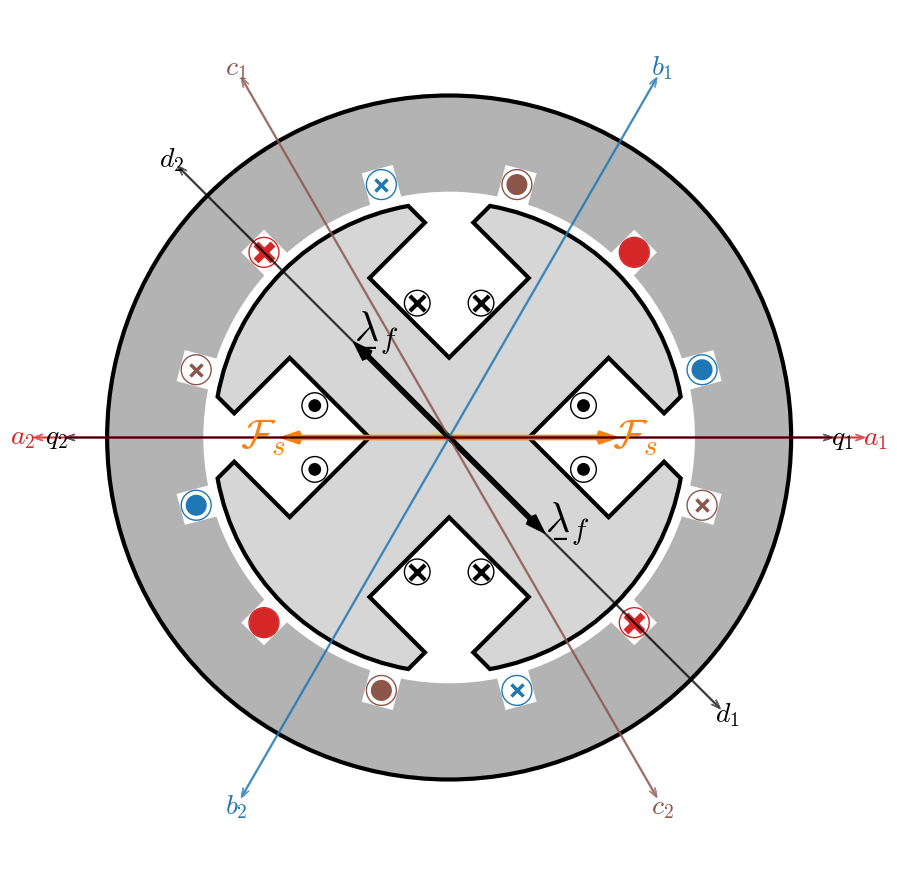

In [1]:
from os import linesep
import numpy as np
from numpy import linspace,cos,sin,pi,exp,angle,array,sqrt
from numpy import heaviside as hs
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib.patches import FancyArrow as fa
from matplotlib.path import Path
from matplotlib.patches import PathPatch,Arc
from matplotlib.collections import PathCollection as pc
from matplotlib import animation,transforms,colors
plt.rcParams.update({"font.family" : "sans serif","mathtext.fontset" : "cm"})

def f_abc(t,A,w,theta): # A: amplitude; w: frequency; theta: phase angle
    return A*array([cos(w*t+theta-k*2*pi/3) for k in range(3)])

def abc2ab(abc): #Clarke transformation, abc to alpha-beta
  return sum(2/3*abc[k]*exp(1j*k*2*pi/3) for k in range(3))

def axis_reset(ax): #clear axis for redrawing
  xy=ax.axis(); ax.cla(); ax.axis('off'); ax.set(xlim=xy[:2],ylim=xy[-2:])
  return

def draw_abc_axes(ax,theta,l,labels,colors,alpha=1,width=.005,zorder=2):
  for kk in range(2):
    for k in range(3):
      rot = transforms.Affine2D().rotate(pi/3*k+kk*pi+theta)+ax.transData
      ax.add_patch(fa(0,0,l,0,width=width,head_width=.06,overhang=.8,color=colors[k],
                      alpha=alpha,transform=rot,zorder=zorder))
      ax.text(l*1.05,0,labels[k+3*kk],color=colors[k],size=20,transform=rot,ha='center',va='center')
  return

def draw_qd_axes(ax,theta,l,labels,colors,alpha=1,width=.005,zorder=2):
  for kk in range(2):
    for k in range(2):
      rot = transforms.Affine2D().rotate(-pi/4*k+theta-pi/4+kk*pi)+ax.transData
      ax.add_patch(fa(0,0,l,0,width=width,head_width=.06,overhang=.8,color=colors[-2],
                      alpha=alpha,transform=rot,zorder=zorder))
      ax.text(l*1.05,0,labels[k+2*kk],color=colors[-2],size=20,transform=rot,ha='center',va='center')
  return

def draw_coductors_in_slots(ax,r,theta,clst,stator=1): #stator=-1 for rotor
  for k in range(12):
    rot = transforms.Affine2D().rotate(pi/6*k+theta)+ax.transData
    ax.add_patch(mp.Rectangle((r-.2+.1*stator,-.15),.4,.3,fc=clst[-1],transform=rot)) #slots
    ax.add_patch(mp.Circle((r+.15*stator,0),.14,color=clst[(1-k)%3],fc='none',lw=1,
                           transform=rot)) #conductors
  return
def draw_current_polarities(ax,r,clst,theta=0,abc=[1,1,1]): #current polarities
  for kk in range(2):
    for k in range(3):
      rot = transforms.Affine2D().rotate(pi/3*k+kk*pi+pi/4-(1-hs(abc[k],0))*pi/2+theta)+ax.transData
      ax.add_patch(mp.Circle((r,0),.13*sqrt(abs(abc[k])),color=clst[k],transform=rot)) #dot
      rot = transforms.Affine2D().rotate(pi/3*k+kk*pi-pi/4-(1-hs(abc[k],0))*pi/2+theta)+ax.transData
      ax.scatter(r,0,s=150*abs(abc[k]),marker='x',lw=5*abs(abc[k]),color=clst[k],transform=rot)#cross
  return

def draw_stator(ax,ord,ird,clst,alpha=1): #stator with axes
  """ord: outter radius; ird: inner radius"""
  ax.add_patch(mp.Circle((0,0),ord,color=clst[-2],lw=3,fc=(.7,.7,.7,1),alpha=alpha))
  ax.add_patch(mp.Circle((0,0),ird,color=clst[-2],lw=0,fc=clst[-1],alpha=alpha))
  draw_coductors_in_slots(ax,ird,pi/12,clst)
  return

def draw_rotor(ax,r,clst,theta=0,alpha=1): #rotor w/ rotor/stator axes
  a = 70 # pole pitch in degrees
  x,y=exp(-1j*.5*a/180*pi).real,exp(-1j*.5*a/180*pi).imag
  rot = transforms.Affine2D().rotate(theta).scale(r)+ax.transData
  arcs = [Path.arc(-a/2+90*k,a/2+90*k) for k in range(4)]
  v,c=[],[]
  d = .24 #rotor pole dimension
  for k in range(4): #salient rotor shape with arcs and lines
    pts = np.array([d-1j*d,x-.1-1j*d,x-.1+1j*y,x-.1-1j*y,x-.1+1j*d])*exp(1j*pi/2*k)
    v.append(list(zip(pts[:3].real,pts[:3].imag)))
    v.append(arcs[k].vertices)
    v.append(list(zip(pts[-2:].real,pts[-2:].imag)))
    c.extend([Path.LINETO]*4)
    c.extend(arcs[k].codes[1:])
    c.extend([Path.LINETO]*2)
  v.append([0,0])
  verts = np.vstack(v)
  codes = ([Path.MOVETO]+c[1:]+[Path.CLOSEPOLY])
  ax.add_patch(PathPatch(Path(verts,codes),ec=clst[-2],fc=(.8,.8,.8,.8),lw=3,transform=rot))
  draw_abc_axes(ax,0,3.8,['$a_1$','$b_1$','$c_1$','$a_2$','$b_2$','$c_2$'],clst,width=.01,alpha=.7) #stator axes
  draw_qd_axes(ax,theta,3.5,['$q_1$','$d_1$','$q_2$','$d_2$'],clst,width=.01,alpha=.6) #rotor axes
  for k in range(4):
    rot = transforms.Affine2D().rotate(theta+k*pi/2)+ax.transData
    ax.add_patch(mp.Circle((.5*r,d*r+.15),.12,ec=clst[-2],fc='none',transform=rot))
    ax.add_patch(mp.Circle((.5*r,-d*r-.15),.12,ec=clst[-2],fc='none',transform=rot))
    ax.add_patch(mp.Circle((.5*r,(d*r+.15)*(-1)**(k+1)),.06,fc=clst[-2],ec='none',transform=rot))#dots
    ax.scatter(.5*r,(d*r+.15)*(-1)**k,s=120,marker='x',lw=3,color=clst[-2],transform=rot)#crosses
  return

def draw_vectors(ax,ab,clst,theta=0,vns=['','','','','']):
  as1 = {'width':.04,'length_includes_head':True,'overhang':-.1} #arr style
  as2 = {'width':.02,'length_includes_head':True,'overhang':.3} #arr style
  for k in range(2):
    rot = transforms.Affine2D().rotate(theta)+ax.transData
    ax.add_patch(fa(0,0,(-1)**k*ab.real,(-1)**k*ab.imag,**as1,color=clst[-2])) #stator vector ab
    ax.text((-1)**k*ab.real*1.1,(-1)**k*ab.imag*1.1,vns[-2],size=30,color=clst[-2],va='center',ha='center')
    ax.add_patch(fa(0,0,(ab*exp(-1j*(pi/4+k*pi))).real*.8,(ab*exp(-1j*(pi/4+k*pi))).imag*.8,**as1,color=clst[-1])) #rotor field flux vector
    ax.text((ab*exp(-1j*(pi/4+k*pi))).real*.8,(ab*exp(-1j*(pi/4+k*pi))).imag*.8,vns[-1],size=30,color=clst[-1])
  return

#parameters
Nfps = 600 #number of frames
ord_s,ird_s,ord_r = 3.2,2.3,2.2 #stator outter/inner radi, rotor outter radius
fe =1 #frequency
Is,fs,phi_s=2.5,fe,0 #stator flux amplitude,frequency,phase
t=linspace(0,2/fe,Nfps)
is_abc = f_abc(t,Is,2*pi*fs,phi_s) #stator flux linkages
is_ab = abc2ab(is_abc) #stator flux vector

#plotting
xylim = [[-4,4] for _ in range(2)]
clst=['tab:red','tab:blue','tab:brown','tab:purple','tab:green','tab:orange','k','w'] #colors light bg
fig = plt.figure(figsize=(9,9))
axs,lines = [[] for _ in range(2)]
for k in range(2):
  axs.append(fig.add_axes((.025,.025,.95,.95),xlim=xylim[0],ylim=xylim[1],fc='none'))
  axs[k].axis('off')
for k in range(3):
   lines.append(axs[0].plot([],[],'-',lw=2,color=clst[k],alpha=.7)[0]) #abc vector sum

# animation function. This is called sequentially
def animate(i):
  if i%50==0: print(i)
  axis_reset(axs[1]) #clear axis
  draw_current_polarities(axs[1],ird_s+.15,clst,abc=is_abc[:,i]/Is) #stator currents
  draw_rotor(axs[1],ord_r,clst,theta=pi*(fs-0)*t[i]+pi/4)
  draw_vectors(axs[1],is_ab[i]**.5,clst[:3]+clst[5:7],
               vns=[r'$i_{as}$',r'$i_{bs}$',r'$i_{cs}$',
                     r'$\mathcal{F}_{s}$',r'$\lambda\underbar_{f}$']) #
  return
draw_stator(axs[0],ord_s,ird_s,clst)
anim = animation.FuncAnimation(fig, animate, frames=Nfps)
anim.save("ElectricMachine_SalientFourPole.mp4", writer=animation.FFMpegWriter(fps=30),dpi = 200)